In [1]:
COPY_DATA = False
SAVE_MODEL = True

DATAPATH = '../data/'
XFERPATH = '~/gdrive/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906142054.csv'
VALID_FNAME = 'embed_valid_201906142054.csv'
TEST_FNAME = 'embed_test_201906142054.csv'
LSTM_TRAIN_FNAME = 'activ_train_201907032046.csv'
LSTM_VALID_FNAME = 'activ_valid_201907032046.csv'
LSTM_TEST_FNAME = 'activ_test_201907032046.csv'
POOL_TRAIN_FNAME = 'activ_train_201907041131.csv'
POOL_VALID_FNAME = 'activ_valid_201907041131.csv'
POOL_TEST_FNAME = 'activ_test_201907041131.csv'

MODEL_TYPE_ID = 'lrp3'

In [2]:
train_from = XFERPATH + TRAIN_FNAME
valid_from = XFERPATH + VALID_FNAME
test_from = XFERPATH + TEST_FNAME
lstm_train_from = XFERPATH + LSTM_TRAIN_FNAME
lstm_valid_from = XFERPATH + LSTM_VALID_FNAME
lstm_test_from = XFERPATH + LSTM_TEST_FNAME
if COPY_DATA:
    !cp $train_from $DATAPATH
    !cp $valid_from $DATAPATH
    !cp $test_from $DATAPATH
    !cp $lstm_train_from $DATAPATH
    !cp $lstm_valid_from $DATAPATH
    !cp $lstm_test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201907041223'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,116,77182,20189,20846,11,18693
815783987784187904,2019-05-24 15:36:01+00:00,False,-10180,-54973,23295,-20926,-2923,10973
3458239641,2019-05-24 19:00:37+00:00,False,-47975,-25760,12054,57238,18813,29521
1003729876250226688,2019-05-26 12:53:00+00:00,True,-13465,74146,9292,102728,7242,-46039
2360143940,2019-05-28 03:50:46+00:00,False,1160,-2419,-48361,36310,47470,-31694


In [6]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34146, 513) (10914, 513) (10450, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [7]:
df_train_lstm = pd.read_csv(DATAPATH+LSTM_TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid_lstm = pd.read_csv(DATAPATH+LSTM_VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test_lstm = pd.read_csv(DATAPATH+LSTM_TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train_lstm.head().iloc[:,:7]

,,male,activ0,activ1,activ2,activ3,activ4,activ5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,208329,272917,-232952,361499,114593,-280181
815783987784187904,2019-05-24 15:36:01+00:00,False,-17652,-21131,65560,-60671,-35859,85437
3458239641,2019-05-24 19:00:37+00:00,False,-10612,8708,56736,-36488,-57626,103292
1003729876250226688,2019-05-26 12:53:00+00:00,True,115526,234496,-143965,274234,73038,-176876
2360143940,2019-05-28 03:50:46+00:00,False,103081,143957,-113044,186899,56687,39322


In [8]:
print(df_train_lstm.shape, df_valid_lstm.shape, df_test_lstm.shape)
print(df_train_lstm.index.get_level_values(1).min(), df_train_lstm.index.get_level_values(1).max())
print(df_valid_lstm.index.get_level_values(1).min(), df_valid_lstm.index.get_level_values(1).max())
print(df_test_lstm.index.get_level_values(1).min(), df_test_lstm.index.get_level_values(1).max())

(34146, 241) (10914, 241) (10450, 241)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [9]:
df_train_pool = pd.read_csv(DATAPATH+POOL_TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid_pool = pd.read_csv(DATAPATH+POOL_VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test_pool = pd.read_csv(DATAPATH+POOL_TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train_pool.head().iloc[:,:7]

,,male,activ0,activ1,activ2,activ3,activ4,activ5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,473435,818899,655267,386695,340486,404179
815783987784187904,2019-05-24 15:36:01+00:00,False,-8503,55833,248860,761147,-1345,-15644
3458239641,2019-05-24 19:00:37+00:00,False,278651,485597,195801,292252,-1345,349903
1003729876250226688,2019-05-26 12:53:00+00:00,True,473435,905348,689134,336728,604330,515917
2360143940,2019-05-28 03:50:46+00:00,False,597550,418546,655267,895473,547918,830661


In [10]:
print(df_train_pool.shape, df_valid_pool.shape, df_test_pool.shape)
print(df_train_pool.index.get_level_values(1).min(), df_train_pool.index.get_level_values(1).max())
print(df_valid_pool.index.get_level_values(1).min(), df_valid_pool.index.get_level_values(1).max())
print(df_test_pool.index.get_level_values(1).min(), df_test_pool.index.get_level_values(1).max())

(34146, 401) (10914, 401) (10450, 401)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [11]:
df_train.drop(['male'],axis=1).mean().mean()

221.5754129555802

In [12]:
df_train_lstm.drop(['male'],axis=1).mean().mean()

16982.058741507055

In [13]:
df_train_pool.drop(['male'],axis=1).mean().mean()

234960.27494596734

In [14]:
scaledown_lstm = 7
scaledown_pool = 700
npc = 30

In [15]:
df_train_final = df_train.join(df_train_lstm.drop(['male'],axis=1)/scaledown_lstm, rsuffix='lstm').join(
                               df_train_pool.drop(['male'],axis=1)/scaledown_pool, rsuffix='pool')
df_valid_final = df_valid.join(df_valid_lstm.drop(['male'],axis=1)/scaledown_lstm, rsuffix='lstm').join(
                               df_valid_pool.drop(['male'],axis=1)/scaledown_pool, rsuffix='pool')
df_test_final = df_test.join(df_test_lstm.drop(['male'],axis=1)/scaledown_lstm, rsuffix='lstm').join(
                               df_test_pool.drop(['male'],axis=1)/scaledown_pool, rsuffix='pool')
df_train_final.shape, df_valid_final.shape, df_test_final.shape

((34344, 1153), (10950, 1153), (10504, 1153))

In [16]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train_final)
X_valid, y_valid = getxy(df_valid_final)
X_test, y_test = getxy(df_test_final)

In [17]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.0807134  0.06568471 0.03352049 0.02719917 0.02543261 0.02134582
 0.02013941 0.01901336 0.01744596 0.01689277 0.01605119 0.0149427
 0.01461687 0.01375327 0.01319985 0.01264759 0.01246494 0.01171725
 0.0114677  0.01109773 0.01086534 0.01037769 0.01027376 0.01004571
 0.00986951 0.00959273 0.00921974 0.00899822 0.00855151 0.00828037
 0.00813803 0.00795114 0.00772495 0.00758095 0.00741138 0.00733595
 0.00728862 0.00716848 0.00703851 0.00691741 0.00683863 0.00652787
 0.00646817 0.00630114 0.00627126 0.00613312 0.00600697 0.00597013
 0.00586868 0.00576312 0.00560589 0.00554329 0.00551702 0.00545614
 0.00535125 0.0052748  0.0052231  0.00509672 0.00508628 0.00496642
 0.00491792 0.00483686 0.00477322 0.00470913]


In [18]:
model = Pipeline([('pca',  PCA(npc)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [20]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train_final, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.6959847036328871

In [21]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid_final, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3406 2057]
 [1901 3586]]


0.6443845462713387

In [22]:
accuracy_score(y_valid, y_pred>.5)

0.6385388127853882

In [23]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test_final, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3217 2038]
 [1856 3393]]


0.6353932584269664

In [24]:
accuracy_score(y_test, y_test_pred>.5)

0.6292840822543793

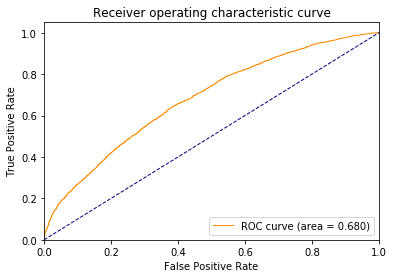

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

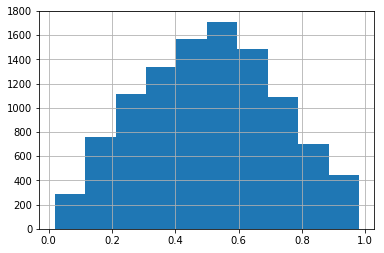

In [26]:
pd.Series(y_test_pred).hist()
plt.show()

In [27]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    acc = accuracy_score(y_test[mask], y_test_pred[mask]>.5)
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 'accuracy':[acc]})
    df_acc = pd.concat([df_acc, row])
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy
minprob,maxprob,,
0.0,0.1,186,0.865591
0.1,0.2,718,0.771588
0.2,0.3,1163,0.681857
0.3,0.4,1394,0.620516
0.4,0.5,1612,0.523573
0.5,0.6,1775,0.541972
0.6,0.7,1513,0.594845
0.7,0.8,1093,0.630375
0.8,0.9,686,0.768222


In [28]:
if SAVE_MODEL:
    from joblib import dump
    model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
    dump(model, model_path)

In [29]:
model_path

'../data/lrp3_model_201907041223.joblib'